In [1]:
"""
LTI Gaussian processes abstraction (basic)
Given
    -  x^+= A x + Bu + Ew
    -  z = Cx+Fv
Do :
    - Quantify eps,
    - Abstract to finite MDP
    Remark that since there is no order reduction,
     there is also no delta error.

Author Sofie Haesaert
"""


'\nLTI Gaussian processes abstraction (basic)\nGiven\n    -  x^+= A x + Bu + Ew\n    -  z = Cx+Fv\nDo :\n    - Quantify eps,\n    - Abstract to finite MDP\n    Remark that since there is no order reduction,\n     there is also no delta error.\n\nAuthor Sofie Haesaert\n'

In [2]:

from ApprxSimulation.LTI_simrel import tune_dratio
from ApprxSimulation.Visualize import plot_regions
from Models.MDP import Rpol
from label_abstraction.test_mdp import test_mdp_dfsa, formula_to_mdp, test_ltl_synth2
# Import packages:
from Models.Linear import LTI, POMDP
from label_abstraction.mdp import *
import matplotlib.pyplot as plt
import polytope as pc


print('Imported packages')


Imported packages


In [3]:


print('Initialise values')
# Define the linear time invariant system
#A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.eye(2) #np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  #array([[1], [0.1]])
W = np.array([[.4,-0.2],[-0.2,0.4]]) #2*Tr.dot(np.eye(dim)).dot(Tr)  # noise on transitions
 
# Accuracy
C = np.array([[1, 0]])  # defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None


Initialise values


In [4]:

# Define spaces
sys_lti.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-1, 1]])))) # continuous set of inputs
sys_lti.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space


# Define regions of interest for the labeling
regions = dict()
regions['target'] = pc.box2poly(np.kron(np.ones((2, 1)), np.array([[5, 10]])))
# add avoid
regions['avoid'] = pc.box2poly(np.array([[-5, 3],[-10, 5]]))

x =pc.extreme(regions['target'])
y =pc.extreme(regions['avoid'])


In [5]:
import matplotlib.patches
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
patch = matplotlib.patches.Polygon(x)
ax.add_patch(patch)

patch = matplotlib.patches.Polygon(y)
ax.add_patch(patch)

plt.xlim([-10,20])
plt.ylim([-10,20])



(-10, 20)

In [6]:
import numpy.linalg as LA
print('1.  Transform to normalised state space')
sys_n = sys_lti.normalize()
x = pc.extreme(regions['target'])
y = pc.extreme(regions['avoid'])

xtr = LA.inv(sys_n.T2x).dot(x.T)
print(xtr)
patch = matplotlib.patches.Polygon(xtr.T)
ax.add_patch(patch)
# 
patch = matplotlib.patches.Polygon(LA.inv(sys_n.T2x).dot(y.T).T)
ax.add_patch(patch)

plt.xlim([-20,20])
plt.ylim([-20,20])
 



1.  Transform to normalised state space
[[ -3.53553  -0.        3.53553  -0.     ]
 [ 10.6066   14.14214  10.6066    7.07107]]


(-20, 20)

2.  Tune gridding ratio


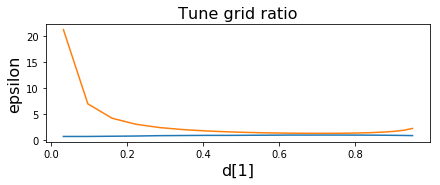

('Choose grid ribs as', array([[ 0.73796],
       [ 0.67484]]))


In [7]:

## step 1: tune gridding ratio (find optimal horizontal d_1, and vertical d_2)
# currently only available for 2D
print('2.  Tune gridding ratio')
d_opt, d_vals, eps_values = tune_dratio(sys_n)
# d_opt has optimal ratio with grid diameter of 1
# choose grid sizes (factor of d_opt)
d = d_opt #  with distance measure
print('Choose grid ribs as', d)    # *Grid space


3.  Grid Gaussian process
[[-0.70711  0.70711]
 [ 0.70711  0.70711]]
Warning no inputspace given
Warning no state space given


status: optimal
optimal epsilon 1.00403642175
optimal M [[ 0.69906 -0.2823 ]
 [-0.2823   0.73808]]
Optimal K [[ 0.81269 -0.60436]
 [-3.8271  -3.61877]]


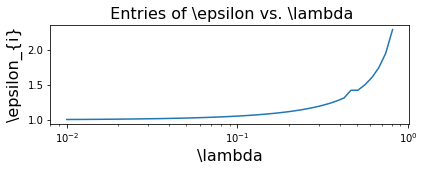

((1721, 49), (49, 1721, 1721))
--- done gridding


In [8]:

print('3.  Grid Gaussian process')
print(sys_n.T2x)
mdp_grid = sys_n.abstract_io(d, un=7, verbose=False)  # do the gridding
print('--- done gridding')


In [9]:
print('4.  Define formula and compute DFA')

formula = '( ( ! avoid U target ) & ( F avoid ) )'

# figure out a map dict_input2prop from numeric inputs to name based inputs
dfsa, init, final, dict_input2prop = formula_to_mdp(formula)

mdp_grid.map_dfa_inputs(dict_input2prop, regions)
mdp_grid.setdfa(dfsa,final)


4.  Define formula and compute DFA
& U ! avoid target F avoid
['avoid', 'target']
{0: (), 1: ('avoid',), 2: ('target',), 3: ('avoid', 'target')}
set([1])
[[ 0.99863 -0.05226]
 [ 0.03447  1.51425]
 [-0.99863  0.05226]
 [-0.03447 -1.51425]]
[[ 0.99863 -0.05226]
 [ 0.03447  1.51425]
 [-0.99863  0.05226]
 [-0.03447 -1.51425]]


In [21]:

print('5. Compute recursions')

mdp_grid.policy= None
mdp_grid.trans_qs = None
V, policy, W = mdp_grid.reach_dfa(recursions = 20)


5. Compute recursions


In [22]:
pol = None
pol = Rpol(mdp_grid, V, W, policy)

pol.set_regions(dict_input2prop, regions)


In [12]:
print('6. Plot normalized systen')

xi, yi = np.meshgrid(*mdp_grid.srep)

plt.pcolor(mdp_grid.sedge[0], mdp_grid.sedge[1],  W[:-1].reshape(xi.shape, order='F'))
plt.colorbar()
plt.xlim(np.array([mdp_grid.srep[0][0],mdp_grid.srep[0][-1]]))
plt.ylim(np.array([mdp_grid.srep[1][0],mdp_grid.srep[1][-1]]))
#plt.show()

xi, yi = np.meshgrid(np.linspace(mdp_grid.srep[0][0],mdp_grid.srep[0][-1],10),np.linspace(mdp_grid.srep[1][0],mdp_grid.srep[1][-1],10))

# compute inputs
u =sys_n.b.dot(pol.cst(np.block([[xi.flatten()],[yi.flatten()]]) ))
delx = (-np.block([[xi.flatten()],[yi.flatten()]])
        +sys_n.a.dot(np.block([[xi.flatten()],[yi.flatten()]])) 
        + sys_n.b.dot(pol.cst(np.block([[xi.flatten()],[yi.flatten()]]))))
x_tr = (np.block([[xi.flatten()], [yi.flatten()]]))

#plt.quiver(xi.flatten(), yi.flatten(),u[0],u[1])
plt.quiver(x_tr[0],x_tr[1],delx[0],delx[1], color = 'r')


6. Plot normalized systen


In [23]:

plt.show()


6. Plot concrete systen


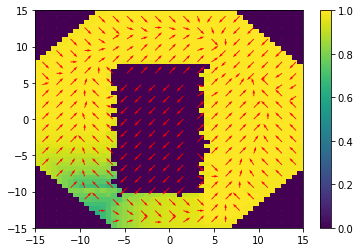

In [14]:
print('6. Plot concrete systen')
fig = plt.figure()
x_edge = np.linspace(-15,15,50)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,50)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)

values = pol.val_concrete(np.block([[xi.flatten()], [yi.flatten()]]))
plt.pcolor(x_edge, y_edge, values.reshape(xi.shape))
plt.colorbar()
plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))

x_edge = np.linspace(-15,15,20)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,20)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)

u =sys_lti.b.dot(pol.cst(np.block([[xi.flatten()],[yi.flatten()]]),transformed = False))
delx = (-np.block([[xi.flatten()],[yi.flatten()]])
        +sys_lti.a.dot(np.block([[xi.flatten()],[yi.flatten()]])) 
        + sys_lti.b.dot(pol.cst(np.block([[xi.flatten()],[yi.flatten()]]),transformed = False)))
x_tr = (np.block([[xi.flatten()], [yi.flatten()]]))

#plt.quiver(xi.flatten(), yi.flatten(),u[0],u[1])
plt.quiver(x_tr[0],x_tr[1],delx[0],delx[1], color = 'r')

plt.show(fig)

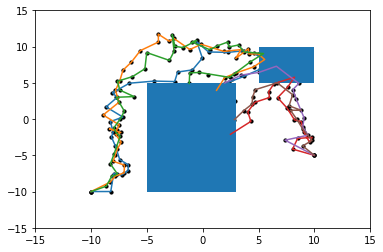

In [24]:
# how to get a nice simulation? 
from random import  gauss 
import random
import scipy.linalg as scla
random.seed(a = '4')
print('final state:', final)
time = 50
fig = plt.figure()
ax = fig.add_subplot(111)
for x0 in (np.array([[-10],[-10]]),np.array([[10],[-5]])):
    for repeating in range(3):
        pol.state = pol.dfa.init[0]
        
        x = np.zeros((2,time+1))
        x[:,[0]] = x0

        for t in range(time): 
            x[:,[t+1]] = (sys_lti.a.dot(x[:,[t]])+sys_lti.b.dot(pol(x[:,[t]], transformed=False )) 
                        + np.array(scla.sqrtm(sys_lti.W)).dot(np.array([[gauss(0,1)],[gauss(0,1)]])))
            if pol.state in final :
                print('reached')
                break
        if not pol.state in final:
            print('not reached')
        plt.plot(x[0,0:t+1],x[1,0:t+1])
        plt.scatter(x[0],x[1], label='Finite states', color='k', s=10, marker="o")

    
plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))
# Define regions of interest for the labeling
regions = dict()
regions['target'] = pc.box2poly(np.kron(np.ones((2, 1)), np.array([[5, 10]])))
# add avoid
regions['avoid'] = pc.box2poly(np.array([[-5, 3],[-10, 5]]))

x =pc.extreme(regions['target'])
y =pc.extreme(regions['avoid'])

patch = matplotlib.patches.Polygon(x)
ax.add_patch(patch)

patch = matplotlib.patches.Polygon(y)
ax.add_patch(patch)
 


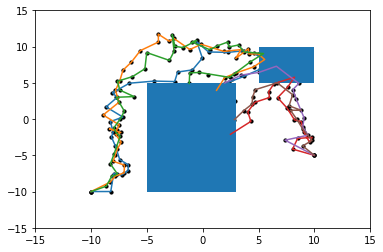

In [25]:


plt.show()


In [17]:
mdp_grid.dfa.Tmat[2].todense()

array([[ 0.73796],
       [ 0.67484]])

In [18]:

d
#
#
#
# # Sensor noise => pomdp
# H = np.ones((1,2)) # what can be measured
# V = np.eye(1)
#     #  x^+= A x + Bu + w
#     #  y = C x
#     #  z = Cz x+v
#
# P= np.eye(2)
# mean = np.zeros((2,1))
#
# pomdp = POMDP(sys, H, V, P, mean)
# Pp = P
# for i in range(15):
#     x, Pu = pomdp.update(mean, Pp)
#     x, Pp = pomdp.predict(np.array([[1],[1]]),x=mean, P=Pu)
#     # updates of x,P
#
# L, Pst = pomdp.kalman()
#
# belief_mdp = pomdp.beliefmodel()
#
#
#
# for i in range(15):
#     (x,P) = belief_mdp.simulate(np.array([[1],[1]]))


array([[ 0.73796],
       [ 0.67484]])

In [19]:
from mdptoolbox.mdp import *
